# Project 2: Time Series Analysis

In [2]:
# Some important libraries to use in time sereies analysis
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels as statsmodels
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
from pandasdmx import Request
import pandas as pd
import os
from statsmodels.stats.diagnostic import acorr_ljungbox


# Setting fixed figure size
plt.rcParams['figure.figsize'] = [10, 7.5]
plt.rcParams.update({'font.size': 18})


#### Importing Lake Huron Data and Plotting it

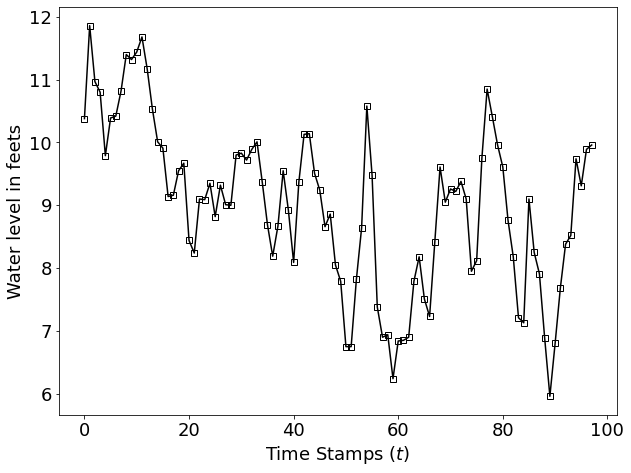

In [3]:
# Obtaining path to data and getting the data
filepath = os.getcwd()
datapath = filepath +"/Data/lakedata.xlsx"
figurepath = filepath+"/Figures"
df = pd.read_excel(datapath)

#plotting data as numpy arrays
data = df.iloc[:,0].to_numpy()
dataTime = np.arange(0,data.shape[0])
plt.figure()
plt.plot(dataTime, data,"k", marker='s', markerfacecolor='none')
plt.xlabel("Time Stamps $(t)$")
plt.ylabel("Water level in feets")

#save figure
plt.savefig(figurepath+"/lakedata.pdf", format="pdf", bbox_inches="tight")
plt.show()


## Using Statsmodels to get autocovariance and plot them

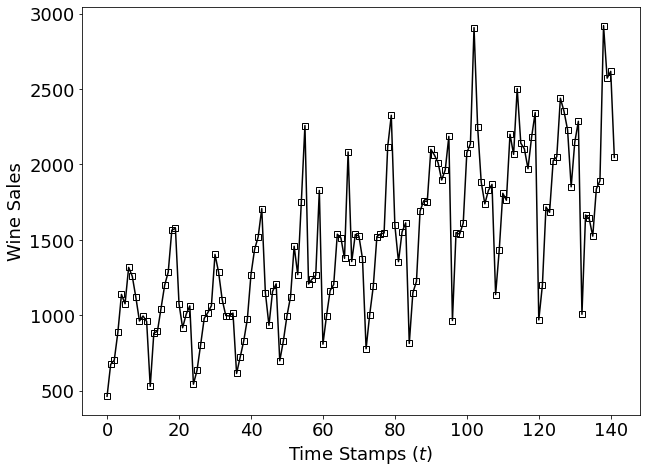

In [4]:
datapathwine = filepath +"/Data/winedata.xlsx"
dfwine = pd.read_excel(datapathwine)

#plotting data as numpy arrays
datawine = dfwine.iloc[:,0].to_numpy()
dataTimeWine = np.arange(0,datawine.shape[0])
plt.figure()
plt.plot(dataTimeWine, datawine,"k", marker='s', markerfacecolor='none')
plt.xlabel("Time Stamps $(t)$")
plt.ylabel("Wine Sales")

#save figure
plt.savefig(figurepath+"/winedata.pdf", format="pdf", bbox_inches="tight")
plt.show()

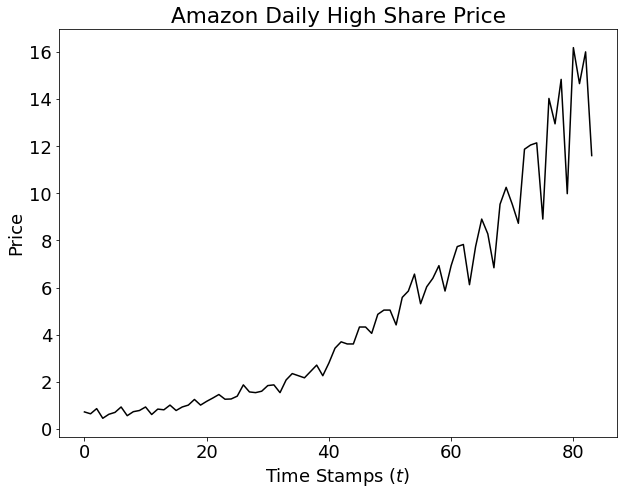

In [80]:
datapathAMZN = filepath +"/Data/jj.xlsx"
df = pd.read_excel(datapathAMZN)

#plotting data as numpy arrays
dataAMZN = df.iloc[:,1].to_numpy()
dataTimeAMZN = np.arange(0,dataAMZN.shape[0])
plt.figure()
plt.plot(dataTimeAMZN, dataAMZN,"k", markerfacecolor='none')
plt.xlabel("Time Stamps $(t)$")
plt.title("Amazon Daily High Share Price")
plt.ylabel("Price")

#save figure
plt.show()

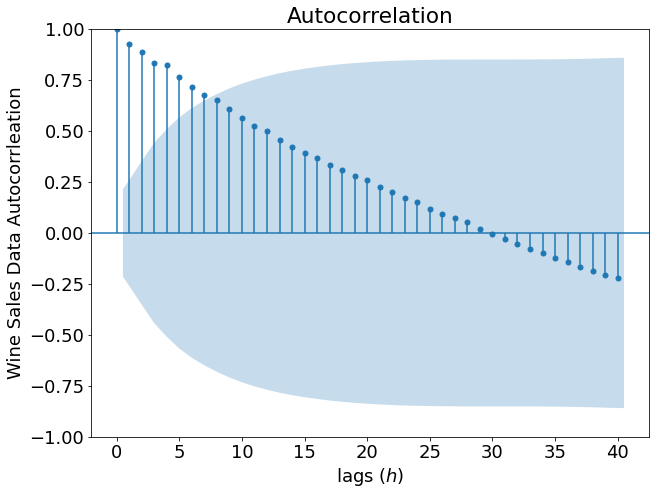

In [83]:
#plotting data as numpy arrays
plot_acf(dataAMZN, lags =40)
plt.xlabel("lags $(h)$")
plt.ylabel("Wine Sales Data Autocorrleation")

#save figure
plt.show()


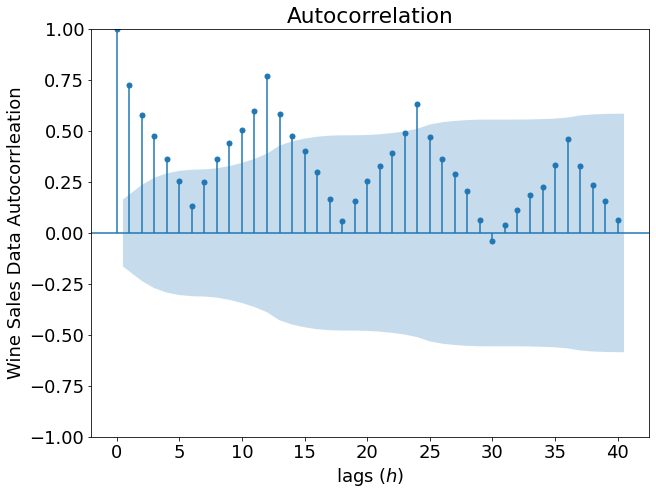

In [84]:

#plotting data as numpy arrays
winedata = dfwine.iloc[:,0].to_numpy()
winedataTime = np.arange(0,data.shape[0])
plot_acf(winedata, lags =40)
plt.xlabel("lags $(h)$")
plt.ylabel("Wine Sales Data Autocorrleation")

#save figure
plt.savefig(figurepath+"/wineautocov.pdf", format="pdf", bbox_inches="tight")
plt.show()



# Stationary Time Series

### Dickey-Fuller Test for Stanionarity 
As the Test statistic is less than the critican values i.e $-0.33518 > \text{min}[-3.482087, -2.884218, -2.578864]$ , the Wine Sales data is not stationary.

In [87]:
#Checking if the data is stationary
result = adfuller(winedata)
# Print test statistic
print(result)

(-0.33518213170815725, 0.9203715733448994, 12, 129, {'1%': -3.482087964046026, '5%': -2.8842185101614626, '10%': -2.578864381347275}, 1741.262969509912)


### Making TS stationary using method of differences
Lets have a look at a non-stationary time series data. Data is about passanger outbound flights at Melbourne Airport from 1985 to 2022. Data Sournce is __[here](https://www.bitre.gov.au/publications/ongoing/airport_traffic_data)__.

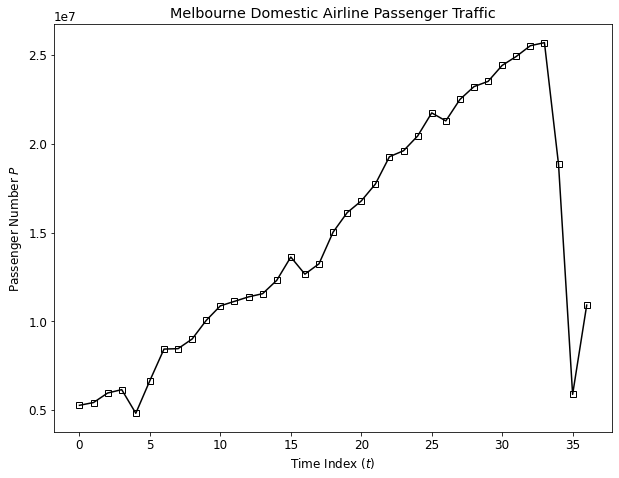

In [9]:
series = pd.read_csv(filepath+'/Data/passengerdata.csv', header=0, index_col=0)
X = series.values
X = np.asarray(X,dtype = float).squeeze()
plt.rcParams.update({'font.size': 12})

plt.plot( X,  "k", marker='s', markerfacecolor='none')
plt.title('Melbourne Domestic Airline Passenger Traffic')
plt.ylabel("Passenger Number $P$")
plt.xlabel("Time Index $(t)$")
#save figure
plt.savefig(figurepath+"/MelbAirport.pdf", format="pdf", bbox_inches="tight")
plt.show()


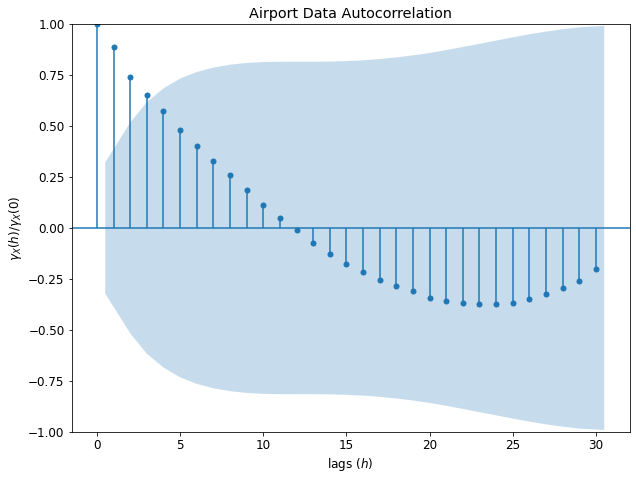

In [10]:
#plot ACVF
plot_acf(X, lags =30)
plt.xlabel("lags $(h)$")
plt.ylabel("$\gamma_X(h) / \gamma_X(0)$")
plt.title("Airport Data Autocorrelation")
plt.show()

As the test statistic is greater than our threshold $(-2.3326> \text{max}([-3.63274, -2.94851, -2.613017]))$, this time series is not stationary.

In [11]:
#ADF test
result = adfuller(X)
print(result)

(-1.2781740552572067, 0.6390976231933112, 2, 34, {'1%': -3.639224104416853, '5%': -2.9512301791166293, '10%': -2.614446989619377}, 844.2678396897555)


### Converting Non-stationary time series to Stationary Time series
We will use differencing to make the series stationary.

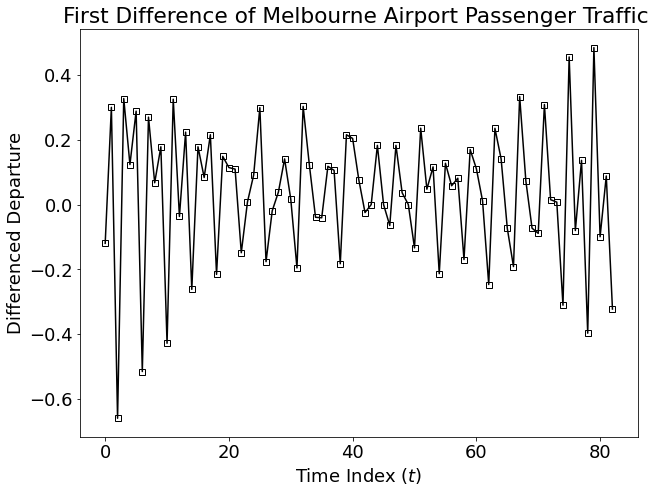

In [90]:
X_diff = np.log(dataAMZN[1:]) - np.log(dataAMZN[0:-1])
plt.plot( X_diff,  "k", marker='s', markerfacecolor='none')
plt.title('First Difference of Melbourne Airport Passenger Traffic ')
plt.ylabel("Differenced Departure")
plt.xlabel("Time Index $(t)$")
#save figure
plt.savefig(figurepath+"/MelbADiff.pdf", format="pdf", bbox_inches="tight")
plt.show()

The series is now stationary.

In [91]:
#ADF test
result = adfuller(X_diff)
print(result)

(-4.317043945811843, 0.00041497314044405543, 5, 77, {'1%': -3.518281134660583, '5%': -2.899878185191432, '10%': -2.5872229937594873}, -140.7202208245293)


# Fiting $\text{MA(n)}$ model

#### We can simulate MA series by sepcifing MA and AR polynomial coefficients.

In [14]:
plt.rcParams.update({'font.size': 18})

ar1 = np.array([1,0])
ma1 = np.array([1, 0, 2])
ARMA_1 = ArmaProcess(ar1,ma1).generate_sample(nsample=200)

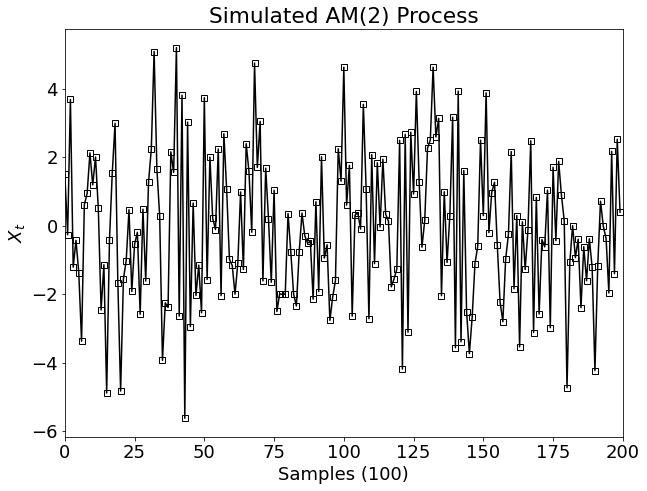

In [15]:
plt.plot( ARMA_1,  "k", marker='s', markerfacecolor='none')
plt.title('Simulated AM(2) Process')
plt.xlim([0,200])
plt.ylabel("$X_t$")
plt.xlabel("Samples (100)")
#save figure
plt.savefig(figurepath+"/MA2.pdf", format="pdf", bbox_inches="tight")
plt.show()

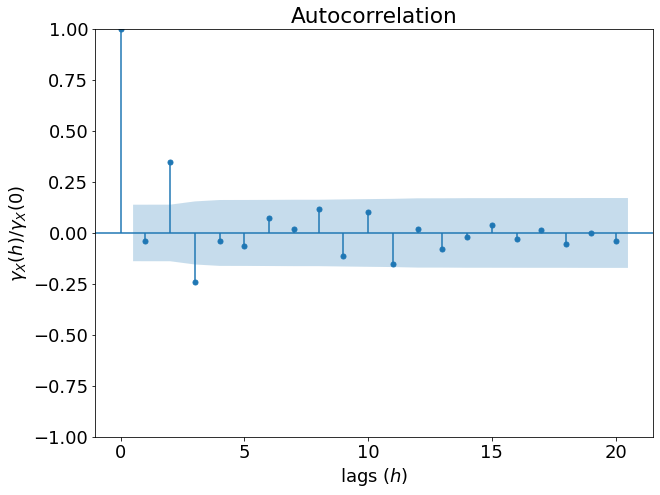

In [16]:
#plot ACVF
plot_acf(ARMA_1, lags =20)
plt.xlabel("lags $(h)$")
plt.ylabel("$\gamma_X(h) / \gamma_X(0)$")
plt.savefig(figurepath+"/MA2corr.pdf", format="pdf", bbox_inches="tight")
plt.show()

#### We can alo grab the information and plot it in style we prefer.

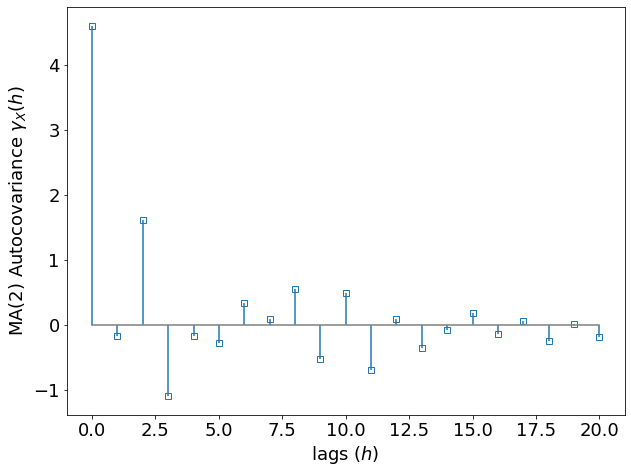

In [17]:
simulated_acv = statsmodels.tsa.stattools.acovf(ARMA_1,nlag =20)
markerline, stemlines, baseline = plt.stem(range(len(simulated_acv)),simulated_acv, markerfmt="s", basefmt="C7")
markerline.set_markerfacecolor('None')
plt.xlabel("lags $(h)$")
plt.ylabel("MA(2) Autocovariance $\gamma_X(h)$")
plt.savefig(figurepath+"/MA2covCustom.pdf", format="pdf", bbox_inches="tight")
plt.show()

#### Statsmodels can also calculate theoretical ACVF

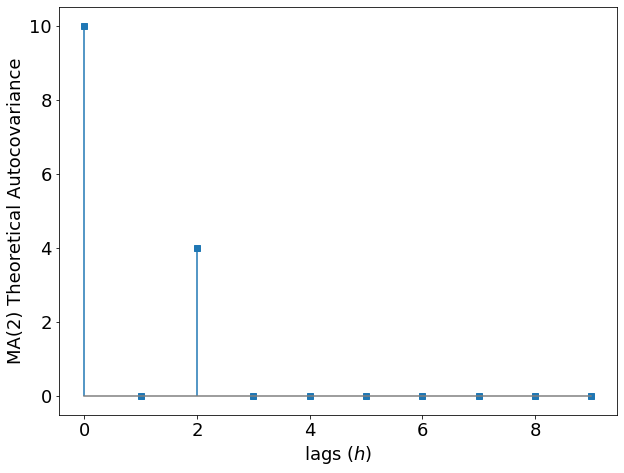

In [18]:
acvf = statsmodels.tsa.arima_process.arma_acovf(ar1, ma1, nobs=10, sigma2=2, dtype=None)
plt.stem(range(len(acvf)),acvf, markerfmt='s',  basefmt="C7")
plt.xlabel("lags $(h)$")
plt.ylabel("MA(2) Theoretical Autocovariance")
plt.savefig(figurepath+"/MA2theoreticalACVF.pdf", format="pdf", bbox_inches="tight")
plt.show()

### MA Fit of Lake Huron Data

Check for Stationarity using Dicky-Fuller Test

In [19]:
#Checking if the data is stationary
result = adfuller(data)
# Print test statistic
print(result)


(-3.8976683843687763, 0.0020520736790759007, 1, 96, {'1%': -3.5003788874873405, '5%': -2.8921519665075235, '10%': -2.5830997960069446}, 179.33694888946826)


### Forecsting out of sample data.

In [117]:
modelMA = ARIMA(data[0:-1], order=(0,0,2)) 
resultsMA = modelMA.fit()

# Make predictions for the test set
forecastMA = resultsMA.predict(start=0, end=98)
## get MSE
MSE_MA =((data - forecastMA[0:-1])**2).mean()

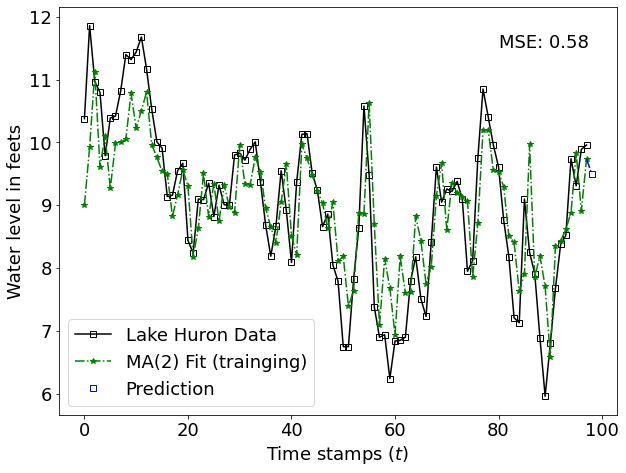

In [118]:
predtimes = np.arange(0,len(forecastMA))
plt.figure()
plt.plot(dataTime, data,  "k", marker='s', markerfacecolor='none')
plt.plot(predtimes[0:-1], forecastMA[0:-1], 'g*-.')
plt.plot(predtimes[-1], forecastMA[-1], 'bs', markerfacecolor='none')
plt.plot(predtimes[-2:], forecastMA[-2:], 'b-.') 
plt.xlabel("Time stamps $(t)$")
plt.ylabel("Water level in feets")
plt.legend(["Lake Huron Data", "MA(2) Fit (trainging)", "Prediction"])
plt.text(80, 11.5, "MSE: {:.2f}".format(MSE_MA))

#save figure
plt.show()

In [ ]:
# Model summary
print(resultsMA.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   97
Model:                 ARIMA(0, 0, 2)   Log Likelihood                -110.791
Date:                Fri, 07 Jul 2023   AIC                            229.581
Time:                        20:59:11   BIC                            239.880
Sample:                             0   HQIC                           233.745
                                 - 97                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.0077      0.197     45.702      0.000       8.621       9.394
ma.L1          1.0136      0.090     11.252      0.000       0.837       1.190
ma.L2          0.5007      0.102      4.900      0.0

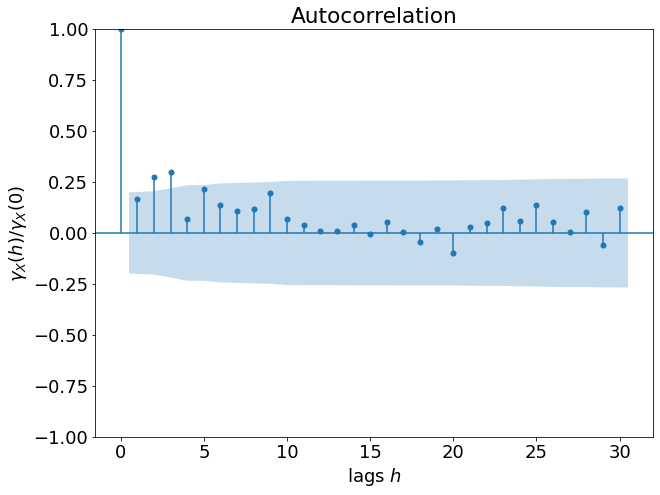

In [ ]:
plot_acf(resultsMA.resid,lags = 30)
plt.xlabel("lags $h$")
plt.ylabel("$\gamma_X(h)/\gamma_X(0)$")
plt.show()

Note that most of the lb_pvalue are below 0.05,hence the residuals are not IID, this can also be deduced from the autocorrelation $\rho_X(h)$ plot given there are more than one significant autocorrelation.

In [ ]:
# Ljung-Box test of MA model
result = acorr_ljungbox(resultsMA.resid)
print(result)

      lb_stat  lb_pvalue
1    2.838493   0.092030
2   10.407859   0.005495
3   19.439281   0.000222
4   19.936322   0.000514
5   24.753113   0.000155
6   26.691181   0.000165
7   27.945525   0.000225
8   29.421509   0.000267
9   33.543600   0.000107
10  34.088250   0.000178


# Fitting an $\text{AR}(n)$ model

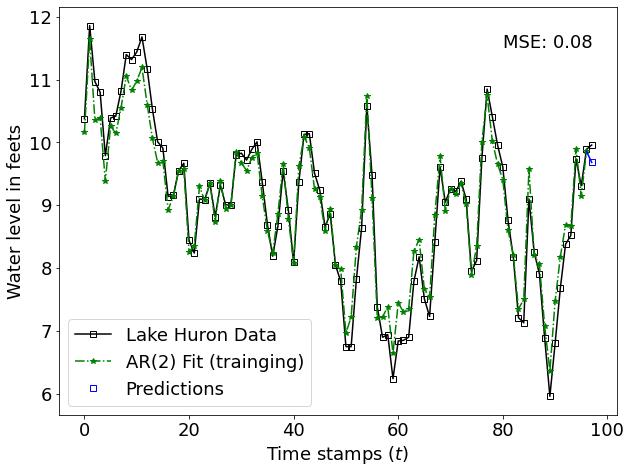

In [ ]:
modelAR = ARIMA(data[0:-1], order=(2,0,0)) 
resultsAR = modelAR.fit()
# Make predictions for the test set
forecastAR = resultsAR.predict(start=1, end=98)
MSE_AR =((data - forecastAR[0:98])**2).mean()

predtimes = np.arange(0,len(forecastAR))
plt.figure()
plt.plot(dataTime, data,  "k", marker='s', markerfacecolor='none')
plt.plot(predtimes[0:-1], forecastAR[0:-1], 'g*-.')
#connect the plots
plt.plot(predtimes[-1], forecastAR[-1], 'bs', markerfacecolor='none')
plt.plot(predtimes[-2:], forecastAR[-2:], 'b') 
plt.xlabel("Time stamps $(t)$")
plt.ylabel("Water level in feets")
plt.legend(["Lake Huron Data", "AR(2) Fit (trainging)", "Predictions"])
plt.text(80, 11.5, "MSE: {:.2f}".format(MSE_AR))

#save figure
plt.show()


In [ ]:
# Model summary
print(resultsAR.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   97
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -103.070
Date:                Fri, 07 Jul 2023   AIC                            214.139
Time:                        20:59:13   BIC                            224.438
Sample:                             0   HQIC                           218.304
                                 - 97                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.0426      0.348     26.004      0.000       8.361       9.724
ar.L1          1.0423      0.092     11.299      0.000       0.861       1.223
ar.L2         -0.2486      0.091     -2.722      0.0

AR(2) gives us IID residuals as shown by the Ljung-box test and the Autocorrelation plot.

In [ ]:
# Ljung-Box test of AR model
result = acorr_ljungbox(resultsAR.resid)
print(result)

     lb_stat  lb_pvalue
1   0.262734   0.608248
2   0.933876   0.626919
3   1.039064   0.791801
4   1.087228   0.896293
5   1.817928   0.873721
6   1.836095   0.934139
7   1.838618   0.968230
8   1.892755   0.984125
9   6.304625   0.709085
10  6.394110   0.781137


 Plot of the residuals after fitting AR model

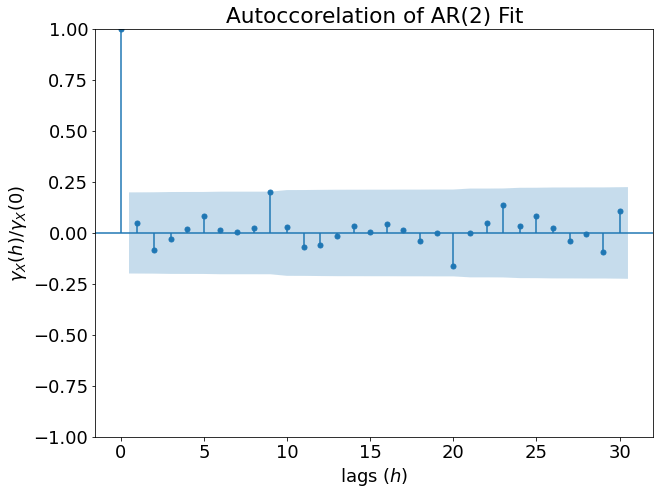

In [ ]:
plot_acf(resultsAR.resid, lags =30)
plt.xlabel("lags $(h)$")
plt.ylabel("$\gamma_X(h) / \gamma_X(0)$")
plt.title("Autoccorelation of AR(2) Fit")
#save figure
plt.show()

# Fitting an $\text{ARMA}(p,q)$ model.
We use a brute force method to find the orders p and q inorder find the best p,q that minimizes our AIC parameter.

In [22]:
def optimize_ARIMA(order_list, data_in):
    """
        Return dataframe with parameters and corresponding AIC
        order_list: list with (p, d, q) tuples. d is fixed
        data_in:    Time Series Data
    """
    
    results = []
    
    for order in order_list:
        try: 
            model = ARIMA(data_in, order=order).fit()
        except:
            continue
            
        aic = model.aic
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df


In [35]:
ps = range(0, 3, 1)
qs = range(0, 3, 1)
# Create a list with all possible combination of parameters
parameters = [(a, b) for a in ps for b in qs]

parameters_list = list(parameters)
order_list = []
for each in parameters_list:
    each = list(each)
    each.insert(1,0)
    each = tuple(each)
    order_list.append(each)
    
result_df = optimize_ARIMA(order_list, data[0:-1])
result_df

c:\Users\yassy\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


,"(p, d, q)",AIC
0,"(1, 0, 1)",213.391727
1,"(2, 0, 0)",214.139305
2,"(1, 0, 2)",215.364390
3,"(2, 0, 1)",215.377056
4,"(2, 0, 2)",216.917087
5,"(1, 0, 0)",217.951999
6,"(0, 0, 2)",229.581018
7,"(0, 0, 1)",253.745836
8,"(0, 0, 0)",332.351733


In [51]:
best_model = ARIMA(data, order=(1,0,1)).fit()
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   98
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -103.245
Date:                Mon, 10 Jul 2023   AIC                            214.491
Time:                        15:34:15   BIC                            224.830
Sample:                             0   HQIC                           218.673
                                 - 98                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.0555      0.359     25.216      0.000       8.352       9.759
ar.L1          0.7449      0.082      9.056      0.000       0.584       0.906
ma.L1          0.3206      0.098      3.286      0.0

In [52]:
# Ljung-Box test
result = acorr_ljungbox(best_model.resid)
print(result)

     lb_stat  lb_pvalue
1   0.071852   0.788659
2   0.113123   0.945008
3   0.421849   0.935693
4   0.425604   0.980327
5   0.836438   0.974651
6   0.837049   0.991043
7   0.869975   0.996663
8   0.885134   0.998875
9   4.975725   0.836419
10  5.017021   0.890038


Lets make out of sample predictions 

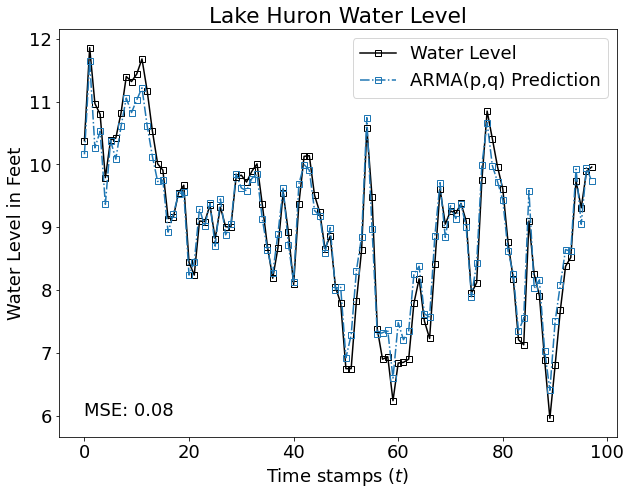

In [53]:
# Make predictions for the test set
forecastARMA = best_model.predict(start=1, end=98)
MSE_ARMA =((data - forecastARMA[0:98])**2).mean()
predtimes = np.arange(0,len(forecastARMA))

plt.figure()
plt.plot(dataTime, data,  "k", marker='s', markerfacecolor='none')
plt.plot(predtimes, forecastARMA, '-.',marker='s', markerfacecolor='none') 
plt.xlabel("Time stamps $(t)$")
plt.ylabel("Water Level in Feet")
plt.legend(["Water Level", "ARMA(p,q) Prediction"])
plt.title("Lake Huron Water Level")
plt.text(0, 6, "MSE: {:.2f}".format(MSE_ARMA))

#save figure
plt.show()

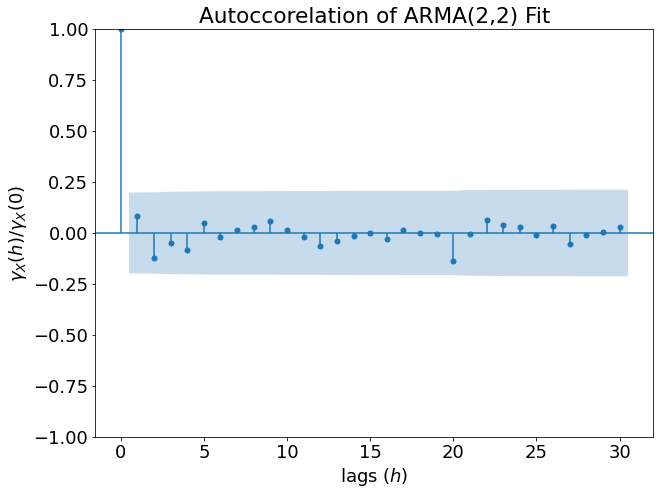

In [ ]:
#Plotting ARMA residuals
plot_acf(best_model.resid, lags =30)
plt.xlabel("lags $(h)$")
plt.ylabel("$\gamma_X(h) / \gamma_X(0)$")
plt.title("Autoccorelation of ARMA(2,2) Fit")
#save figure
plt.show()

# Putting it All together

In [97]:
ps = range(0, 8, 1)
qs = range(0, 8, 1)
# Create a list with all possible combination of parameters
parameters = [(a, b) for a in ps for b in qs]
dataAMZN_log =np.log(dataAMZN)
parameters_list = list(parameters)
order_list = []
for each in parameters_list:
    each = list(each)
    each.insert(1, 1)
    each = tuple(each)
    order_list.append(each)
    
result_df = optimize_ARIMA(order_list, dataAMZN_log[0:-4])
result_df


c:\Users\yassy\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yassy\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yassy\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yassy\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

,"(p, d, q)",AIC
0,"(4, 1, 3)",-132.545878
1,"(4, 1, 1)",-131.948423
2,"(5, 1, 1)",-131.457875
3,"(7, 1, 2)",-131.332301
4,"(4, 1, 2)",-130.983989
...,...,...
59,"(1, 1, 1)",-40.969743
60,"(2, 1, 1)",-39.582016
61,"(2, 1, 0)",-38.585028
62,"(1, 1, 0)",-38.180805


In [101]:
best_model = ARIMA(dataAMZN_log[0:-2], order=(4,1,3)).fit()
print(best_model.summary())

c:\Users\yassy\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   82
Model:                 ARIMA(4, 1, 3)   Log Likelihood                  77.256
Date:                Mon, 10 Jul 2023   AIC                           -138.511
Time:                        15:54:22   BIC                           -119.356
Sample:                             0   HQIC                          -130.826
                                 - 82                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0035      0.061      0.057      0.954      -0.115       0.122
ar.L2          0.0161      0.051      0.317      0.751      -0.083       0.115
ar.L3          0.0223      0.049      0.451      0.6

c:\Users\yassy\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


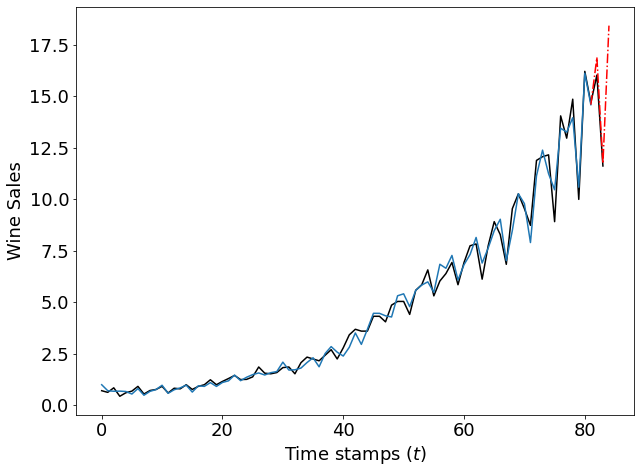

In [115]:
# Make predictions for the test set
end =  dataAMZN_log.shape[0]
forecastARMA = best_model.predict(start=0, end=end)
predtimes = np.arange(0,len(forecastARMA))
ts = np.arange(0,dataAMZN_log.shape[0])
plt.figure()
plt.plot(ts, dataAMZN, "k", markerfacecolor='none')
plt.plot(predtimes[0:-3], np.exp(forecastARMA[0:-3]), markerfacecolor='none') 
plt.plot(predtimes[-4:], np.exp(forecastARMA[-4:]), 'r-.', markerfacecolor='none') 

plt.xlabel("Time stamps $(t)$")
plt.ylabel("Wine Sales")
#plt.legend(["Wine Sales", "ARMA(p,q) Prediction"])

#save figure
plt.show()

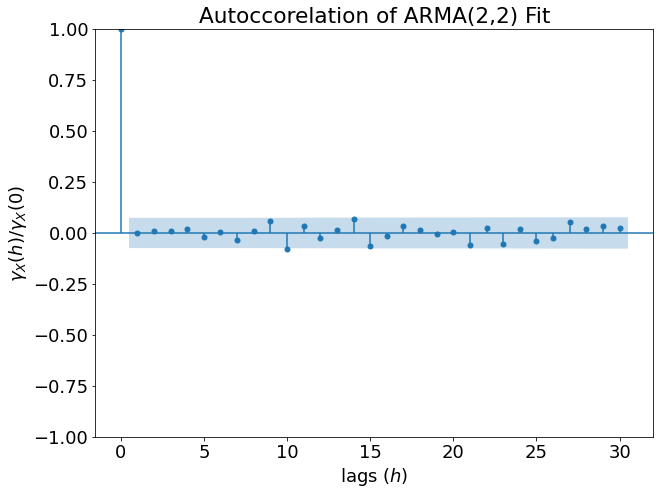

In [96]:
#Plotting ARMA residuals
plot_acf(best_model.resid, lags =30)
plt.xlabel("lags $(h)$")
plt.ylabel("$\gamma_X(h) / \gamma_X(0)$")
plt.title("Autoccorelation of ARMA(2,2) Fit")
#save figure
plt.show()